# Python codes for [Introduction to Computional Stochastic PDEs, CUP 2014](http://www.cambridge.org/gb/academic/subjects/mathematics/differential-and-integral-equations-dynamical-systems-and-co/introduction-computational-stochastic-pdes?format=PB&isbn=9780521728522)

Written by [T. Shardlow](http://people.bath.ac.uk/tjs42/) Dec 2015
# Chapter 8





In [1]:
# load standard set of Python modules
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import sys
if sys.version_info < (3,):
    try:
        from builtins import (bytes, dict, int, list, object, range, str,
                              ascii, chr, hex, input, next, oct, open,
                              pow, round, super, filter, map, zip)
        from future.builtins.disabled import (apply, cmp, coerce, execfile,
                                              file, long, raw_input,
                                              reduce, reload,
                                              unicode, xrange, StandardError)
    except:
        print("need future module")

In [2]:
from math import *
# Numpy
import numpy as np
from numpy import matlib
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Scipy
import scipy
from scipy import sparse
from scipy.sparse import linalg
from scipy import optimize
# Numba
from numba import jit, f8

The basic method for numerically approximating SDEs in time is the Euler-Maruyama method.

In [3]:
def EulerMaruyama(u0,T,N,d,m,fhandle,ghandle):
    """
    Alg 8.1 Page 331
    """
    Dt=T / N
    u=np.zeros((d,N + 1))
    t=np.linspace(0,T,N+1)
    sqrtDt=sqrt(Dt)
    u[:,0]=u0
    u_n=np.copy(u0)
    for n in range(N):
        dW=sqrtDt * np.random.randn(m)
        u_new=u_n + Dt * fhandle(u_n) + np.dot(ghandle(u_n), dW)
        u[:,n + 1]=u_new
        u_n=u_new
    return t,u

In [4]:
def vdp(u0,T,N,alpha,lam,sigma):
    """
    Alg 8.2 Page 331
    """
    t,u=EulerMaruyama(u0,T,N,2,1,
                      lambda u: vdp_f(u,lam,alpha),
                      lambda u: vdp_g(u,sigma))
    return t,u
#
@jit([f8[:](f8[:],f8,f8)])
def vdp_f(u,lam,alpha):
    """
    Helper function Alg 8.2
    """
    f=np.array([u[1],
                - u[1] * (lam + u[0] ** 2) + alpha * u[0] - u[0] ** 3]    )
    return f
#
@jit([f8[:](f8[:],f8)])
def vdp_g(u,sigma):
    """
    Helper function Alg 8.2
    """
    g=np.array([0, sigma * u[0]])
    g.shape=(g.size,1)# force column vector
    return g

We present an example of the Euler-Maruyama approximation of the van der Poll-Duffing SDE.

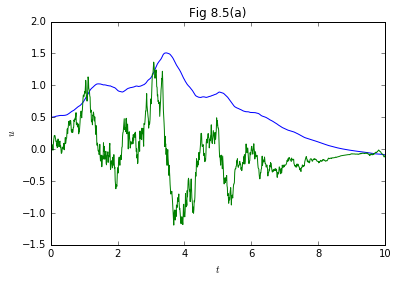

In [5]:
lam=1; alpha=1; sigma=1;
u0=np.array([0.5, 0])
T=10
N=1000
[t,u]=vdp(u0,T,N,alpha,lam,sigma)
#
plt.plot(t,u[0,:])
plt.plot(t,u[1,:])
s=plt.xlabel(r'$t$')
s=plt.ylabel(r'$u$')
s=plt.title(r'Fig 8.5(a)')

The Milstein method can be used to achieve higher rates of convergence. We implement when the diffusion is diagonal.

In [6]:
def MilsteinDiag(u0,T,N,d,m,fhandle,ghandle,dghandle):
    """
    Alg 8.3 Page 334
    """
    Dt=T / N
    u=np.zeros((d,N + 1))
    t=np.linspace(0,T,N+1)
    sqrtDt=sqrt(Dt)
    u[:,0]=u0
    u_n=np.copy(u0)
    for n in range(N):
        dW=sqrtDt * np.random.randn(m)
        gu_n=ghandle(u_n)
        u_new=(u_n + Dt * fhandle(u_n) + np.dot(gu_n,dW)
               + 0.5 * (dghandle(u_n)*gu_n)* (dW ** 2 - Dt))
        u[:,n + 1]=u_new
        u_n=u_new
    return t,u

A simple example with geometric Brownian motion.

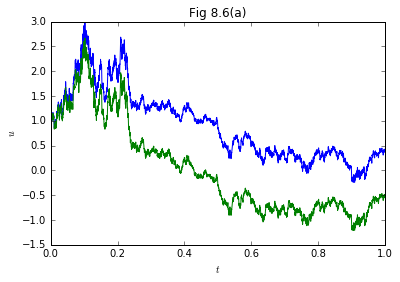

In [7]:
d=2; m=2;
A=np.array([[1,0],[0,-1]])
sigma=np.array([1,2])
T=1; N=5000;u0=np.array([1,1])
t,u=MilsteinDiag(u0,T,N,d,m,
                lambda u: A.dot(u),
                lambda u: sigma*u,
                lambda u: sigma)
#
plt.plot(t,u[0,:])
plt.plot(t,u[1,:])
s=plt.xlabel(r'$t$')
s=plt.ylabel(r'$u$')
s=plt.title(r'Fig 8.6(a)')

It's natural to introduce implicitness in the drift and the next codes implements the classical $\theta$-method in the drift part of the SDE.

In [8]:
def EulerMaruyamaTheta(u0,T,N,d,m,fhandle,ghandle,theta):
    """
    Alg 8.4 Page 338
    """
    Dt=T / N
    u=np.zeros((d,N + 1))
    t=np.linspace(0,T,N+1)
    sqrtDt=sqrt(Dt)
    u[:,0]=u0
    u_n=np.copy(u0)
    for n in range(N):          # 
        dW=sqrtDt * np.random.randn(m)
        u_explicit=u_n + Dt * fhandle(u_n) + np.dot(ghandle(u_n), dW)
        if (theta > 0):
            v=u_n + (1 - theta) * Dt * fhandle(u_n) + np.dot(ghandle(u_n), dW)
            u_new=scipy.optimize.fsolve(
                lambda u: - u + v + theta * fhandle(u) * Dt,
                u_explicit)
        else:
            u_new=u_explicit
        u[:,n+1]=u_new
        u_n=u_new
    return t,u

Here we present an example with geometric Brownian motion.

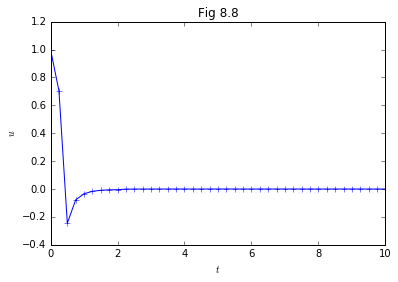

In [9]:
u0=1; T=10; N=40; d=1; m=1; theta=1;
r=-8; sigma=3;
t,u=EulerMaruyamaTheta(u0,T,N,d,m,
                        lambda u: r*u,
                        lambda u: sigma*u,
                        theta)
#
plt.plot(t,u[0,:],'+-')
s=plt.xlabel(r'$t$')
s=plt.ylabel(r'$u$')
s=plt.title(r'Fig 8.8') # theta=1 only

To study strong convergence, we generate sample paths from the SDE and refine them.

In [10]:
def EMpath(u0,T,N,d,m,fhandle,ghandle,kappa0,M,s0):
    """
    Alg 8.5 Page 343
    """
    Dtref=T / N
    Dt=kappa0 * Dtref
    NN=N // kappa0
    u=np.zeros((d,M,NN + 1))
    t=np.linspace(0,T,NN)
    gdW=np.zeros((d,M))
    sqrtDtref=sqrt(Dtref)
    u_n=np.copy(u0)
    u[:,:,0]=u_n   
    for n in range(NN ):
        dW=sqrtDtref * np.sum(s0.randn(kappa0,m,M),axis=0)
        for mm in range(M):
            gdW[:,mm]=np.dot(ghandle(u_n[:,mm]) , dW[:,mm])
        u_new=u_n + Dt * fhandle(u_n) + gdW
        u_n=u_new
        u[:,:,n+1]=u_n
    
    return t,u
#
def runEMpath(u0,T,Nref,d,m,fhandle,ghandle,kappa,M):
    """
    Alg 8.6 Page 346
    """
    S=0
    Mstep=1000
    m0=0
    s0=np.random.RandomState()
    
    for mm in range(0,M,Mstep):
        MM=min(Mstep,M - mm )
        u00=u0[:,mm:m0 + MM ]
        s0_state=s0.get_state()
        tref,uref=EMpath(u00,T,Nref,d,m,fhandle,ghandle,1,MM,s0)
        s0.set_state(s0_state);
        t,u=EMpath(u00,T,Nref,d,m,fhandle,ghandle,kappa,MM,s0)
        err=u[:,:,-1] - uref[:,:,-1]
        S=S + np.linalg.norm(err,'fro')**2
        m0=m0 + MM
    rmsErr=sqrt(S / M)
    return rmsErr # deleted some return values
#

Here we look at the rate of convergence of Euler-Maruyama in mean square.

[ 0.17378167  0.15473823  0.42100882  0.46232599  2.34628032  3.02231246]


C:\Users\tony\Anaconda\envs\py35\lib\site-packages\matplotlib\axis.py:1015: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
C:\Users\tony\Anaconda\envs\py35\lib\site-packages\matplotlib\axis.py:1025: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


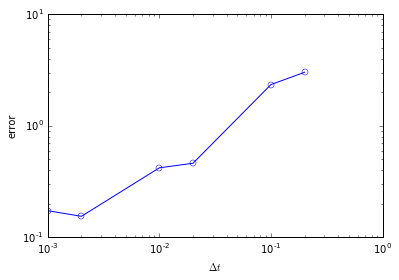

In [11]:
d=2; m=2; T=1; N=5000; Dtref=T/N; M=500
A=np.array([[1,0],[0,-1]])
u0=np.matlib.repmat(np.array([1,1]),M,1).T
  
kappa=np.array([5,10,50,100,500,1000],dtype='int32')
rmsErr=np.zeros(kappa.shape)
for k in range(kappa.size):
        rmsErr[k]=runEMpath(u0,T,N,d,m,
                            lambda u: A.dot(u),
                            lambda u: np.array([[u[0],0],
                                                [0,2*u[1]]]),
                            kappa[k],M)
print(rmsErr)
plt.loglog(Dtref*kappa,rmsErr,'-o',fillstyle='none')
s=plt.xlabel(r'$\Delta t$')
s=plt.ylabel(r'error')

The last group of codes implement the multilevel Monte Carlo method.

In [12]:
def mlmc(u0,T,d,m,fhandle,ghandle,kappa,epsilon,DTMX):
    """
    Alg 8.7 Page 357
    """
    Levels=int(ceil(log(2 * T / epsilon) / log(kappa)) + 1)
    DT=T * kappa ** (- (np.arange(Levels, dtype='float64' )))
    L0=(int)(np.min(np.where(DT <= DTMX)))
    M=10 * np.ones(Levels,dtype='int')
    Ckappa=(1 + 1.0 / kappa)
    S1=np.zeros(Levels)
    S2=np.copy(S1); ML=np.zeros(S1.shape,dtype='int');     VL=np.copy(S1)
    for j in range(L0,Levels):
        N=kappa ** j
        S1,S2=getlevel(u0,T,N,d,m,fhandle,ghandle,kappa,M[j],j,L0,S1,S2)
        VL[L0:j]=S2[L0:j] / M[L0:j] - (S1[L0:j] / M[L0:j]) ** 2
        
        KC=(2 / epsilon ** 2) * sqrt(VL[L0] / DT[L0])
        if j > L0:
            KC=KC + (2/epsilon**2) * np.sum(np.sqrt(VL[L0:j] / DT[L0:j] * Ckappa))
            tmp=np.sqrt(VL[L0:j]* DT[L0:j])
            ML[L0:j]=np.ceil((KC / Ckappa)*tmp)
        else:
            ML[L0]=ceil(KC * sqrt(VL[L0] * DT[L0]))
        for l in range(L0,j):
            dM=ML[l] - M[l]
            if dM > 0:
                N=kappa ** l
                M[l]=M[l] + dM
                S1,S2=getlevel(u0,T,N,d,m,fhandle,ghandle,kappa,dM,l,L0,S1,S2)
    EPu=np.sum(S1[L0:Levels] / M[L0:Levels])
    return EPu,M
#    
def getlevel(u00,T,N,d,m,fhandle,ghandle,kappa,MS,L,L0,S1,S2):
    """
    Alg 8.8 Page 358
    """
    SS1=0;    SS2=0;    Mstep=10000
    s0=np.random.RandomState()
    for M in range(0,MS,Mstep):
        MM=(int)(min(Mstep,MS - M ))
        u0=u00.reshape((d,1))*np.ones((d,MM))
        if L == L0:
            t,u=EMpath(u0,T,N,d,m,fhandle,ghandle,1,MM,s0)
            u=u[:,:,-1]
            SS1=SS1 + np.sum(phi(u))
            SS2=SS2 + np.sum(phi(u) ** 2)
        else:
            s0_state=s0.get_state()
            t,uu=EMpath(u0,T,N,d,m,fhandle,ghandle,1,MM,s0)
            uref=uu[:,:,-1]
            s0.set_state(s0_state);
            t,uu=EMpath(u0,T,N,d,m,fhandle,ghandle,kappa,MM,s0)
            u=uu[:,:,-1]
            X=phi(uref) - phi(u)
            SS1=SS1 + np.sum(X)
            SS2=SS2 + np.sum(X ** 2)
    
    S1[L]=S1[L] + SS1
    S2[L]=S2[L] + SS2
    return S1,S2
#   
def phi(v):
    """
    Helper function for Alg 8.8
    """
    phiv=v[-1,:]
    return phiv

   Here we show the amount of work performed on each level.

In [13]:
d=1; m=1; r=-1; sigma=0.5; u0=np.array([1]);
kappa=2; T=1; DTMX=0.2; epsilon=1e-2;
    
Epu,M=mlmc(u0, T, d, m,
           lambda u: np.array(r*u),
           lambda u: np.array([[sigma*u]]),
           kappa, epsilon, DTMX)   

In [14]:
print('Number of samples on each level',M[np.where(M>10)])
print(Epu)

Number of samples on each level [1702  107   53   21   17]
0.379359907996
